# Notebook to format data from "Behavioural inference from signal processing using animal-borne multi-sensor loggers: a novel solution to extend the knowledge of sea turtle ecology", Jeantet et al (2020).

Data can be found [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.hhmgqnkd9).

[Supplementary material](https://rs.figshare.com/articles/journal_contribution/Supplementary_Tables_and_Figure_from_Behavioural_inference_from_signal_processing_using_animal-borne_multi-sensor_loggers_a_novel_solution_to_extend_the_knowledge_of_sea_turtle_ecology/12279848?backTo=/collections/Supplementary_material_from_Behavioural_inference_from_signal_processing_using_animal-borne_multi-sensor_loggers_a_novel_solution_to_extend_the_knowledge_of_sea_turtle_ecology_/4971233)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/jeantet_turtles'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/jeantet_turtles'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
features_fps = glob.glob(raw_data_dir + '/*.h5')
annotations_fps = glob.glob(raw_data_dir + '/*.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 20
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'jeantet_turtles'

In [6]:
## Integer codes for individuals

clip_id_to_individual_id = {'CC-07-107_11-02-2019' : 0,
 'CC-07-108_11-02-2019' : 1,
 'CC-07-115_13-05-2019' : 2,
 'CC-07-115_14-05-2019' : 3,
 'CC-07-47_14-02-2018' : 4,
 'CC-07-48_04-10-2018' : 5,
 'CC-07-48_06-10-2018' : 6,
 'CC-07-48_08-04-2019_1' : 7,
 'CC-07-48_08-04-2019_2' : 7,
 'CC-07-48_08-04-2019_3' : 7,
 'CC-07-48_08-10-2018' : 8,
 'CC-07-48_10-10-2018' : 9,
 'CC-07-48_18-02-2019' : 10,
 'CC-07-48_22-05-2018' : 11,
 'CC-07-48_26-05-2018' : 12,
 'CC-07-59_20-05-2018' : 13}

clip_ids = list(clip_id_to_individual_id.keys())
dataset_metadata['clip_ids'] = clip_ids

dataset_metadata['individual_ids'] = [i for i in range(14)] # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

In [7]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual)
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [0, 5, 10], 1: [1, 6, 11], 2: [2, 7, 12], 3: [3, 8, 13], 4: [4, 9]}
There are 14 individuals


In [8]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

In [9]:
# Check that each clip has a corresponding annotation file
for clip_id in clip_ids:
    if not os.path.join(raw_data_dir, 'Behaviors_' + clip_id +'.csv') in annotations_fps:
        print('clip id %s does not have corresponding annotations' % clip_id)
        
print("Checked that all clips have corresponding annotations")

Checked that all clips have corresponding annotations


## Create dataset-level metadata

In [10]:
## Integer codes for specific behaviors

# list of behaviors (from Jeantet et al 2020)
beh_names = ['unknown', 
            'breathing', 
            'feeding', 
            'gliding', 
            'resting', 
            'scratching', 
            'staying_at_surface', 
            'swimming']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

# extract directly from the annotations
fp = annotations_fps[0]
all_annotations = pd.read_csv(fp, delimiter = ';')

for fp in annotations_fps[1:]:
    all_annotations = all_annotations.append(pd.read_csv(fp, delimiter = ';'))

In [11]:
# What are the observed labels?

all_annotations['Behavior'].value_counts()

Swimming ascent               774
Swimming descent              773
Swimming horizontally         601
Swimming on the bottom        536
Gliding ascent                497
Right U-turn                  470
Stay in surface               427
Resting                       408
Gliding descent               403
Left U-turn                   403
Breathing                     389
Grabbing stationary           350
Swimming 1 ascent             336
Chewing stationary            303
Resting in flow               271
Swimming 1 horizontally       268
Swimming 1 descent            235
Shaking                       146
Foraging                      145
Prospection                   130
Chewing on movement           127
Grabbing on movement          121
Scratching                    117
Shaking head                   98
Resting watching               89
Obstacle                       53
Watching                       48
Scratching head                47
Flipper beat                   46
Sand          

In [12]:
# Map to beh_labels following supplementary material

observed_labels_to_beh_label = {'Swimming ascent' : 'swimming',
                                'Swimming descent' : 'swimming',
                                'Swimming horizontally' : 'swimming',
                                'Swimming on the bottom' : 'swimming',
                                'Gliding ascent' : 'gliding',
                                'Right U-turn' : 'swimming',
                                'Stay in surface' : 'staying_at_surface',
                                'Resting' : 'resting',
                                'Left U-turn' : 'swimming',
                                'Gliding descent' : 'gliding',
                                'Breathing' : 'breathing',
                                'Grabbing stationary' : 'feeding',
                                'Swimming 1 ascent' : 'swimming',
                                'Chewing stationary' : 'feeding',
                                'Resting in flow' : 'resting',
                                'Swimming 1 horizontally' : 'swimming',
                                'Swimming 1 descent' : 'swimming',
                                'Shaking' : 'unknown',
                                'Foraging' : 'unknown',
                                'Prospection' : 'swimming',
                                'Chewing on movement' : 'feeding',
                                'Grabbing on movement' : 'feeding',
                                'Scratching' : 'scratching',
                                'Shaking head' : 'unknown',
                                'Resting watching' : 'resting',
                                'Obstacle' : 'unknown',
                                'Watching' : 'unknown',
                                'Scratching head' : 'scratching',
                                'Sand' : 'unknown',
                                'Flipper beat' : 'unknown',
                                'Interaction' : 'unknown',
                                'Swimming fast descent' : 'swimming',
                                'Catching' : 'feeding',
                                'Landing' : 'unknown',
                                'Resting active' : 'resting',
                                'New video' : 'unknown',
                                'Swimming fast ascent' : 'swimming',
                                'Escape' : 'unknown',
                                'Scratching camera' : 'scratching',
                                'Catching jellyfish' : 'feeding', 
                                'Swimming in place' : 'swimming',
                                'Swimming fast horizontally' : 'swimming',
                                'Pursuit' : 'unknown',
                                'Grabbing the wall' : 'feeding', 
                                'Stepping back' : 'swimming',
                                'Time mark' : 'unknown',
                                'Regurgitating' : 'unknown',
                                'Chewing jellyfish' : 'feeding',
                                'Hunting jellyfish' : 'unknown'
                               }

In [13]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ', 'Depth', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [14]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [15]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0
total_annotation_dur_samples = 0

for clip_id in clip_ids:
    # load features
    features_fp = os.path.join(raw_data_dir, clip_id + '.h5')
    features_hf = h5py.File(features_fp, 'r')
    features = np.array(features_hf.get('data'))
    static_components = np.zeros((np.shape(features)[0], 3))
    clip_dur_samples = np.shape(features)[0]
    total_dur_samples += clip_dur_samples
    
    # load annotations
    annotations_fp = os.path.join(raw_data_dir, 'Behaviors_' + clip_id + '.csv')
    annotations_df = pd.read_csv(annotations_fp, delimiter = ';')
    annotations_df = annotations_df[['Behavior', 'Start (s)', 'Stop (s)']]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unkown"
    for i, row in annotations_df.iterrows():
        beh_label = observed_labels_to_beh_label[row['Behavior']]
        int_label = beh_str_to_int[beh_label]
        start_sec = row['Start (s)']
        end_sec = row['Stop (s)']
        start_sample = int(start_sec * sr)
        end_sample = int(end_sec * sr)
        per_frame_annotations[start_sample: end_sample, :] = int_label
        
    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    depth = features[:, -1]
    depth = np.expand_dims(depth, axis = 1)
    
    clip_data = np.concatenate([features[:, :6], depth, per_frame_individual_id, per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    
    clip_annotation_dur_samples = np.sum(per_frame_annotations > 0)
    total_annotation_dur_samples += clip_annotation_dur_samples
    

In [16]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 277597.150000 seconds, i.e. 77.110319 hours
total annotation duration is 244043.850000 seconds, i.e. 67.789958 hours


## Check it all looks ok

In [17]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')

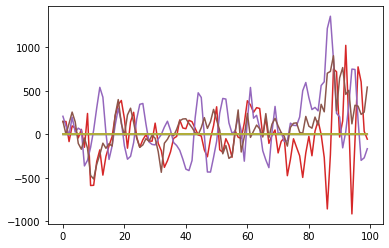

In [18]:
for i in range(np.shape(data)[1]):
    plt.plot(data[1000:1100, i])

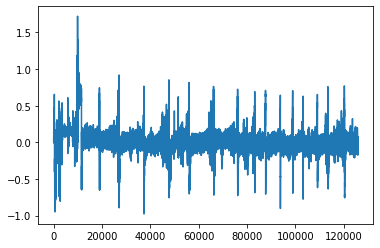

In [19]:
plt.plot(data[:, 0])

## Plot Dataset Summary

In [15]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = float(label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]]))


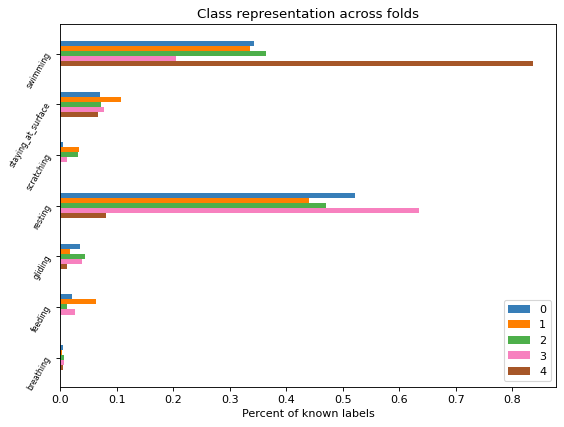

In [19]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.svg')

plt.savefig(target_fp, format = 'svg')
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

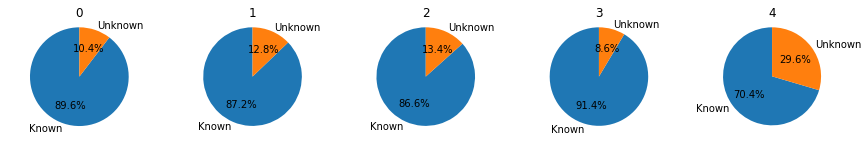

In [20]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.svg')

plt.savefig(target_fp, format='svg')

plt.show()


## Temporal Statistics

In [18]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

Mean overall label duration is 47.204 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/jeantet_turtles/dataset_metadata.yaml
